# EDA for Reviews

In this notebook, I explore the Yelp reviews dataset, obtain summary statistics about the reviews, and generate visualizations for the distribution of values related to reviews. Because Yelp is primarily used for restaurant reviews and discussion, I choose to separate the review text into two corpora: one for businesses tagged with the `restaurant` tag and one for those without the `restaurant` tag.

## Import modules

In [1]:
%run .engine.py

In [3]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

engine = create_engine(LOGIN)

## Query data

Data for this project is stored on a PostgreSQL database hosted on an AWS t2.micro instance.

In [4]:
query = """
SELECT reviews.stars as stars, 
reviews.text as text, 
reviews.useful as useful, 
reviews.funny as funny, 
reviews.cool as cool,
business.state as state,
business.categories as categories
FROM reviews
INNER JOIN business ON reviews.business_id = business.business_id
"""

df = pd.read_sql_query(query, engine)
df.shape

(5261668, 7)

There are approxmiately 5.2 million reviews.

## Add individual category columns, rename all categories to lowercase and remove '&' symbols

Since the business category may influence how users interact with individual businesses pages and therefore with the characteristics of reviews written, I create a set of boolean columns identifying which categories the business each review is for is associated with.

In [5]:
yelpcats = ['Active Life', 'Arts & Entertainment', 'Automotive', 
            'Beauty & Spas', 'Education', 'Event Planning & Services' , 
            'Financial Services', 'Food', 'Health & Medical', 'Home Services', 
            'Hotels & Travel', 'Local Flavor', 'Local Services', 'Mass Media', 
            'Nightlife', 'Pets', 'Professional Services', 'Public Services & Government',
            'Real estate', 'Religious Organizations', 'Restaurants',
            'Shopping']

In [6]:
for i in yelpcats:
    df[i] = df['categories'].map(lambda x: i in x).astype(int)

In [7]:
df.columns = df.columns.map(lambda x: x.lower().replace(' ','_').replace('&', 'and'))

In [8]:
df.drop(['categories'], 1,inplace=True)

## Create review word count column

I also include a feature for the word count of each review as longer, substantial reviews may be more likely to be rated useful by users.

In [10]:
df['review_length'] = df['text'].map(lambda x: len(x.split(' ')))

## Drop reviews from non-English regions

The reviews are sourced from the following cities: Edinburgh (UK), Stuttgart (Germany), Montreal (Canada), Toronto (Canada), Pittsburgh , Charlotte, Champaign-Urbana, Phoenix, Las Vegas, Madison, and Cleveland. 

To attempt to control unexpected input to any text-based model, I chose to eliminate reviews from Edinburgh, Stuttgart, and Montreal as businesses in those metropolitan areas are more likely to have reviewers writing reviews in non-English languages. We will add another language-based filter based on character usage in the text processing notebook.

In [11]:
df['state'].value_counts().head(20)

NV     1824442
AZ     1627792
ON      634366
NC      307665
OH      243768
PA      229850
QC      146371
WI      109751
EDH      47889
IL       36467
BW       35400
SC       10860
MLN       1851
HLD       1288
NYK        733
CHE        727
FL         557
FIF        362
ELN        236
C          202
Name: state, dtype: int64

In [12]:
states_to_keep = ['NV', 'AZ', 'ON', 'NC', 'OH', 'PA', 'WI', 'IL', 'SC']

In [13]:
df = df[df.state.isin(states_to_keep)]

## Save the data 

In [15]:
restaurants = df[df['restaurants']==1]

In [28]:
restaurants.to_csv('../data/restaurants.csv', index=False, compression='gzip')

In [29]:
businesses = df[df['restaurants']==0]

In [30]:
businesses.to_csv('../data/businesses.csv', index=False, compression='gzip')

## Examining the useful votes

In [15]:
df[df['useful']>0]['useful'].mean()

2.9195192757377453

The average number of useful votes for any review with at least 1 useful votes was just under 3 useful votes.

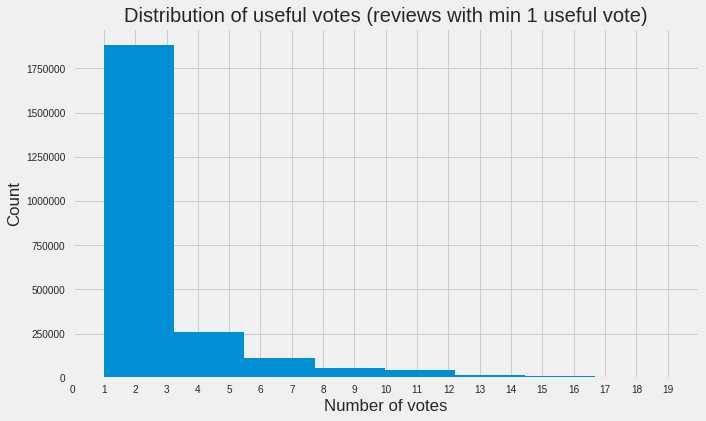

In [24]:
plt.figure(figsize=(10, 6))
df[df['useful'] > 0]['useful'].hist(bins=1500)
plt.title('Distribution of useful votes (reviews with min 1 useful vote)')
plt.xticks(range(0, 20, 1))
plt.xlabel('Number of votes')
plt.xlim(0, 20)
plt.ylabel('Count')
plt.savefig('../visuals/useful_dist.png')

We see that a vast majority of reviews with any useful votes have between 1 and 3 votes.

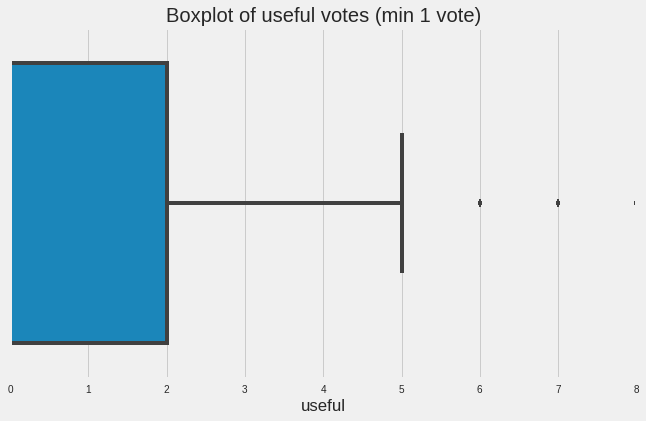

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(df['useful'])
plt.xlim(0, 8)
plt.title('Boxplot of useful votes (min 1 vote)')

The above boxplot that excludes outliers shows that the 75th percentile for useful votes among 'useful' reviews is around 5 votes.

## Useful votes by category

In [34]:
means = []
medians = []
stds = []
votes = []
for col in df.columns[6:-1]:
    means.append(df[df[col]==True]['useful'].mean())
    medians.append(df[df[col]==True]['useful'].median())
    stds.append(df[df[col]==True]['useful'].std())
    votes.append(df[df[col]==True]['useful'].sum())

In [35]:
summary = pd.DataFrame(index=df.columns[6:-1], data={'mean' : means, 
                                                     'std' : stds, 
                                                     'median' : medians, 
                                                     'votes' : votes}).sort_values(by='votes', ascending=False)

In [45]:
summary.drop('real_estate', 0, inplace=True)

In [60]:
summary.head()

,mean,median,std,votes
restaurants,1.147203,0.0,4.944911,3505839
food,1.264512,0.0,7.451163,1414691
nightlife,1.275052,0.0,3.062205,1065187
shopping,1.782177,1.0,3.735898,657069
event_planning_and_services,1.441480,0.0,3.224699,538952


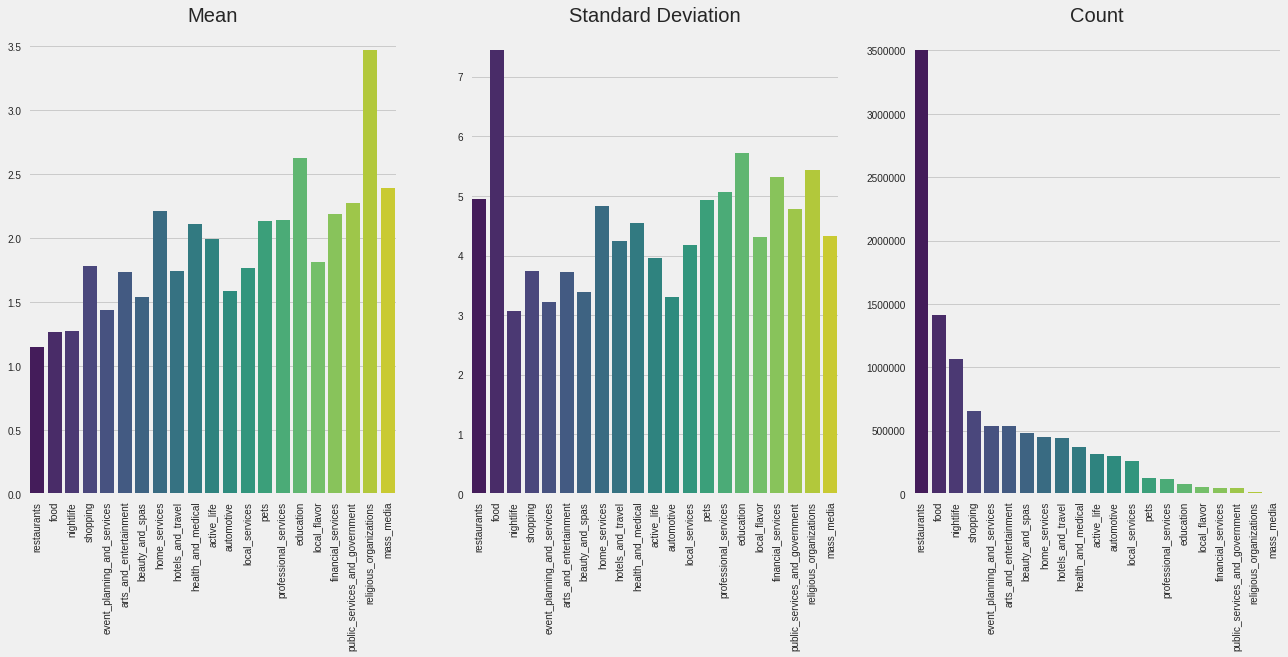

In [84]:
plt.subplots(nrows=1, ncols=3, figsize=(20, 8), sharex=False, sharey=False)

plt.subplot(1, 3, 1)
sns.barplot(x=summary.index, y=summary['mean'].values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Mean')

plt.subplot(1, 3, 2)
sns.barplot(x=summary.index, y=summary['std'].values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Standard Deviation')

plt.subplot(1, 3, 3)
sns.barplot(x=summary.index, y=summary['votes'].values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Count')

plt.savefig('../visuals/useful_stats.png')

First, we see that restaurants and food have the majority of useful votes, which is consistent with our knowledge that Yelp is primarily used for restaurant reviews. We also see that the real estate category has no useful votes. We will thus drop reviews for real estate businesses.

In [14]:
df.drop('real_estate', 1, inplace=True)

# Comparison of useful and not useful reviews

In [85]:
df['is_useful'] = (df['useful'] > 0).astype(int)

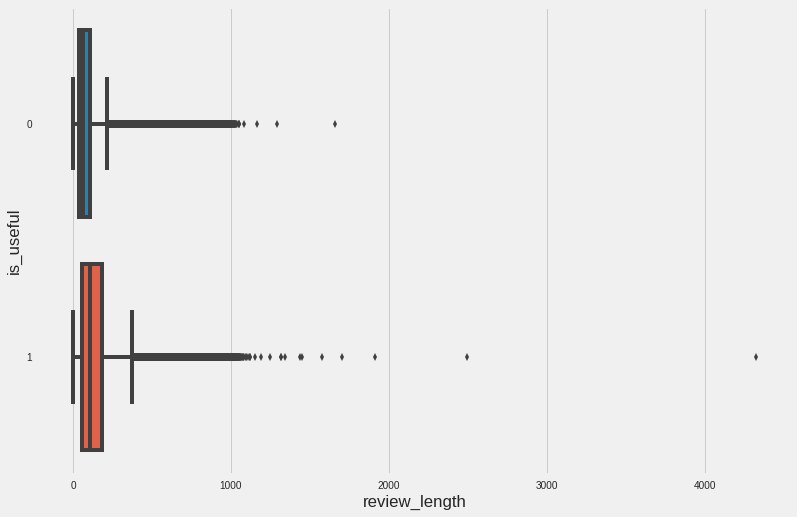

In [86]:
plt.figure(figsize=(12, 8))
sns.boxplot('review_length', 'is_useful', data=df, orient='h')

We can see that several reviews are much longer than the rest based on our 'word count' metric.

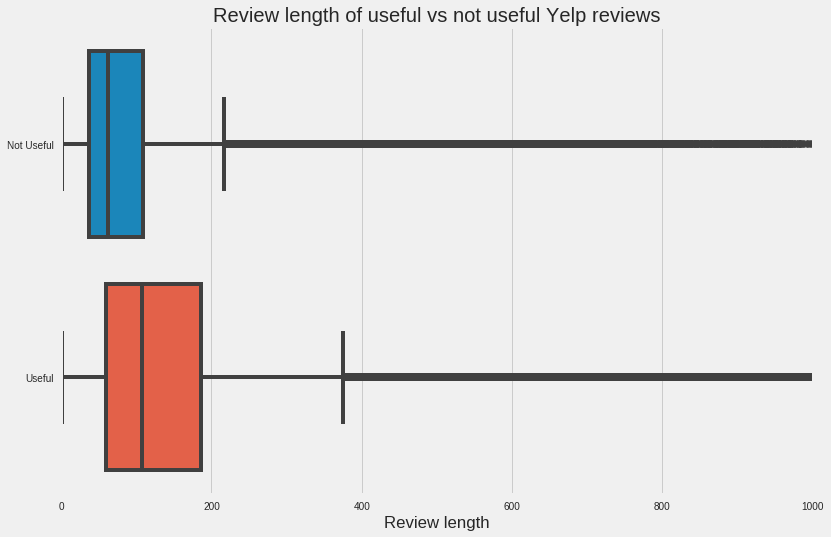

In [90]:
plt.figure(figsize=(12, 8))
sns.boxplot('review_length', 'is_useful', data=df, orient='h')
plt.title('Review length of useful vs not useful Yelp reviews')
plt.xlim(0, 1000)
plt.xlabel('Review length')
plt.yticks([0, 1], ['Not Useful', 'Useful'])
plt.ylabel('')
plt.savefig('../visuals/useful_boxplot.png')

If we look at reviews and cap the review length at 1000 words, we see that in general useful reviews seem to be a little bit longer than the not useful reviews. 

## Review length by star rating

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


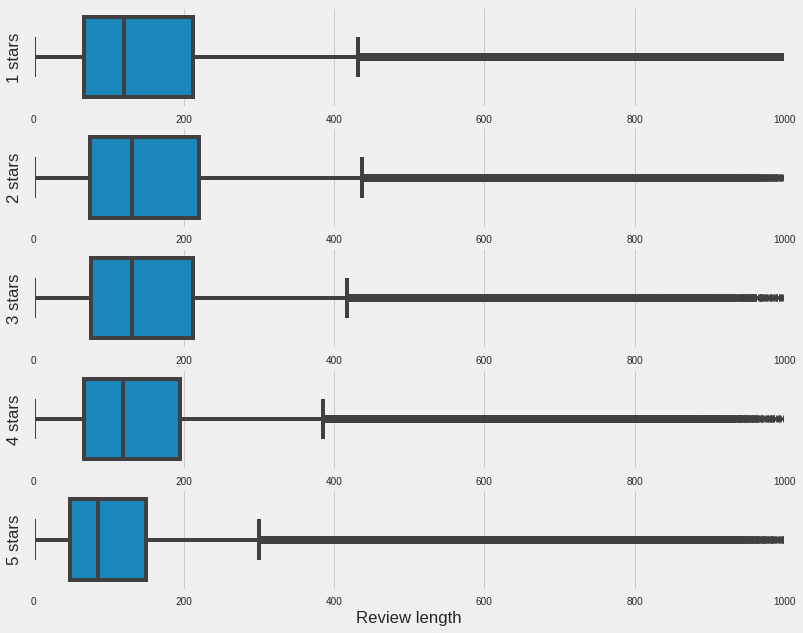

In [97]:
plt.subplots(figsize=(12, 10), sharex=True, sharey=True)
for i in range(1, 6, 1):
    plt.subplot(5, 1, i) 
    sns.boxplot(df[(df['is_useful']==1) & (df['stars'] == i)], df[(df['is_useful']==1) & (df['stars'] == i)]['review_length'], orient='h')
    plt.ylabel(str(i)+' stars')
    plt.xlabel('Review length')
    plt.xlim(0, 1000)
plt.savefig('../visuals/useful_stars.png')

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


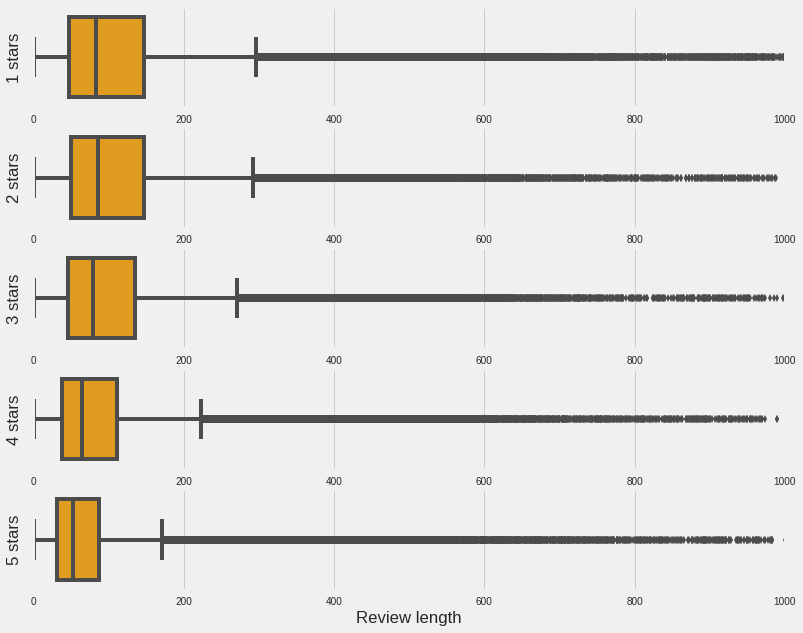

In [96]:
plt.subplots(figsize=(12, 10), sharex=True, sharey=True)
for i in range(1, 6, 1):
    plt.subplot(5, 1, i) 
    sns.boxplot(df[(df['is_useful']==0) & (df['stars'] == i)], df[(df['is_useful']==0) & (df['stars'] == i)]['review_length'], orient='h', color='orange')
    plt.ylabel(str(i)+' stars')
    plt.xlabel('Review length')
    plt.xlim(0, 1000)
plt.savefig('../visuals/notuseful_stars.png')

We can see that overall 5 star reviews seem to be shorter on average, with 'not useful' reviews being shorter than 'useful' reviews.

Overall, it looks like reviews of all levels mostly are 250 words or under. It appears that 5 star reviews may be a little shorter in general (75th percentile at under 200 words for not useful and around 300 words for useful).

## Comparison of vote types (Useful, funny, and cool)

Below, I compare the vote counts in the three user-submitted categories for Yelp reviews: Useful, Funny, and Cool.

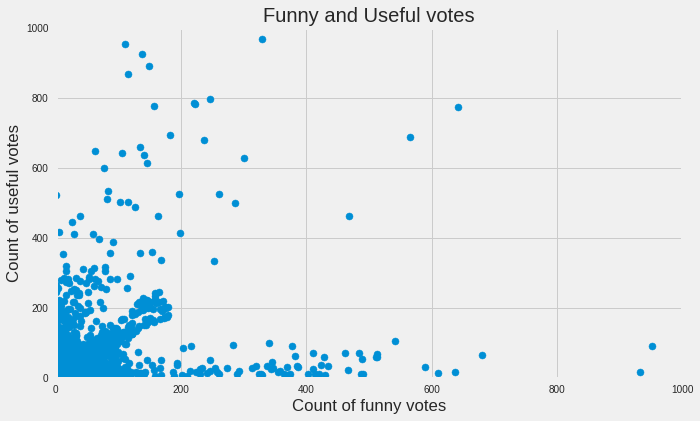

In [100]:
plt.figure(figsize=(10, 6))
plt.scatter('funny', 'useful', data=df)
plt.title('Funny and Useful votes')
plt.xlabel('Count of funny votes')
plt.ylabel('Count of useful votes')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.savefig('../visuals/funny_useful.png')

We see that there are essentially 3 groupings of reviews: 

1. Votes with a high number of funny votes, but very few useful votes in comparison.
2. Votes with an equal number of funny and useful votes (suggesting there is a linear relationship between funny and useful votes up to a certain point)
3. Votes with a high number of useful votes, but very few funny votes.

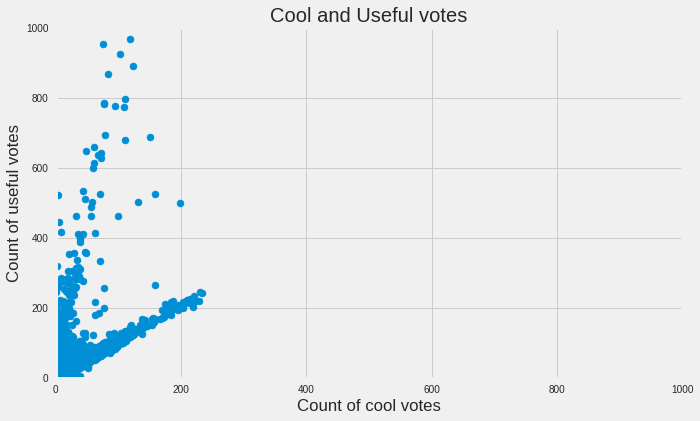

In [101]:
plt.figure(figsize=(10, 6))
plt.scatter('cool', 'useful', data=df)
plt.title('Cool and Useful votes')
plt.xlabel('Count of cool votes')
plt.ylabel('Count of useful votes')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.savefig('../visuals/cool_useful.png')

When comparing cool and useful votes, we see that there are two apparent groups of reviews. A group with equal amounts of useful and cool votes up to around 250 votes, and reviews with a high number of useful votes but no cool votes. We see that there are no reviews with many cool votes, but no useful votes. I choose to drop `cool` as a feature in favor of retaining `funny`. 